# [EXTRA]. Perfil de óbitos por covid no estado do Rio Grande do Sul

Vamos analisar os sintomas/condicoes mais presentes nos pacientes que vieram a obito por covid. Com uma verdadeira análise exploratória

In [1]:
# pacotes padrao
import os, sys, types, time, datetime, math, random, unidecode, collections, re

# Manipulacao de dados
import numpy as np
import pandas as pd

# Visualizacao de dados
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

# Lidando com Warnings 
import warnings
warnings.filterwarnings('ignore')

# plotagem Inline
%matplotlib inline

In [30]:
# carregamento dos dados
df = pd.read_csv("files/covid_2021_cleaned.csv", sep=';')

In [31]:
 # selecao dos obitos
df_obitos = df[df['EVOLUCAO'] == 1]

In [39]:
df['SRAG'].value_counts()

NAO    532537
SIM     51691
Name: SRAG, dtype: int64

In [35]:
df_obitos['SRAG'].value_counts()

SIM    18579
Name: SRAG, dtype: int64

# Análise estatística

Visualização da frequencia de sintomas ou condições nos casos positivos (recuperados x obito):

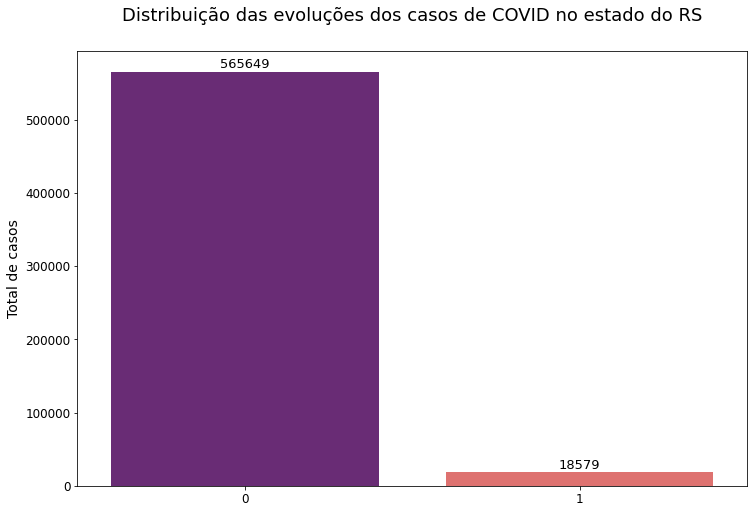

In [32]:
plt.rc('figure', figsize=(12, 8))
ax = sns.countplot(x='EVOLUCAO', data=df, palette='magma')

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2 # divide por 2 pra ficar no meio
            _y = p.get_y() + p.get_height() + 5000 # mais 5000 pra n ficar colado na altura da barra
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize=13, color='black',) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
show_values_on_bars(ax)

ax.set_title('Distribuição das evoluções dos casos de COVID no estado do RS', fontsize=18, pad=30);
ax.set_ylabel('Total de casos', fontsize=14)
ax.set_xlabel('')

ax.tick_params(axis='both', which='major', labelsize=12)

In [38]:
df_recuperados = df[df['EVOLUCAO'] == 0]
print("Total | Porcentagem total | Total recuperados | Porcentagem recuperados | Total óbitos | Porcentagem óbito")
for row in df_recuperados: # só para percorrer, nao importa o df
    print('------------------------------')
    print(row)
    total_rec = df_recuperados[row].value_counts(dropna=False, sort=False)
    total_obitos = df_obitos[row].value_counts(dropna=False, sort=False)
    
    total_rec = total_rec.astype(int) # convert
    total_obitos = total_obitos.astype(int) #convert
    
    total = total_rec.add(total_obitos, fill_value=0)
    porcentagem = df[row].value_counts(dropna=False, normalize=True) * 100
    porcentagem_obitos = (total_obitos.divide(total)) * 100
    porcentagem_recuperados = (total_rec.divide(total)) * 100
    
    print(pd.concat([total, porcentagem, total_rec, porcentagem_recuperados, total_obitos, porcentagem_obitos], 
                    axis=1, keys=['Total', 'Tot %', 'Total Rec', 'Rec %', 'Total Obt', 'Obt %']))
    print('------------------------------')
    

Total | Porcentagem total | Total recuperados | Porcentagem recuperados | Total óbitos | Porcentagem óbito
------------------------------
SEXO
            Total      Tot %  Total Rec      Rec %  Total Obt     Obt %
Feminino   310263  53.106493     301573  97.199150       8690  2.800850
Masculino  273965  46.893507     264076  96.390415       9889  3.609585
------------------------------
------------------------------
FAIXAETARIA
            Total      Tot %  Total Rec      Rec %  Total Obt      Obt %
01 a 04      7407   1.267827       7403  99.945997          4   0.054003
05 a 09      9267   1.586196       9265  99.978418          2   0.021582
10 a 14     13395   2.292769      13390  99.962673          5   0.037327
15 a 19     30292   5.184962      30273  99.937277         19   0.062723
20 a 29    108501  18.571688     108276  99.792629        225   0.207371
30 a 39    121926  20.869592     121168  99.378311        758   0.621689
40 a 49    104102  17.818728     102386  98.351617      

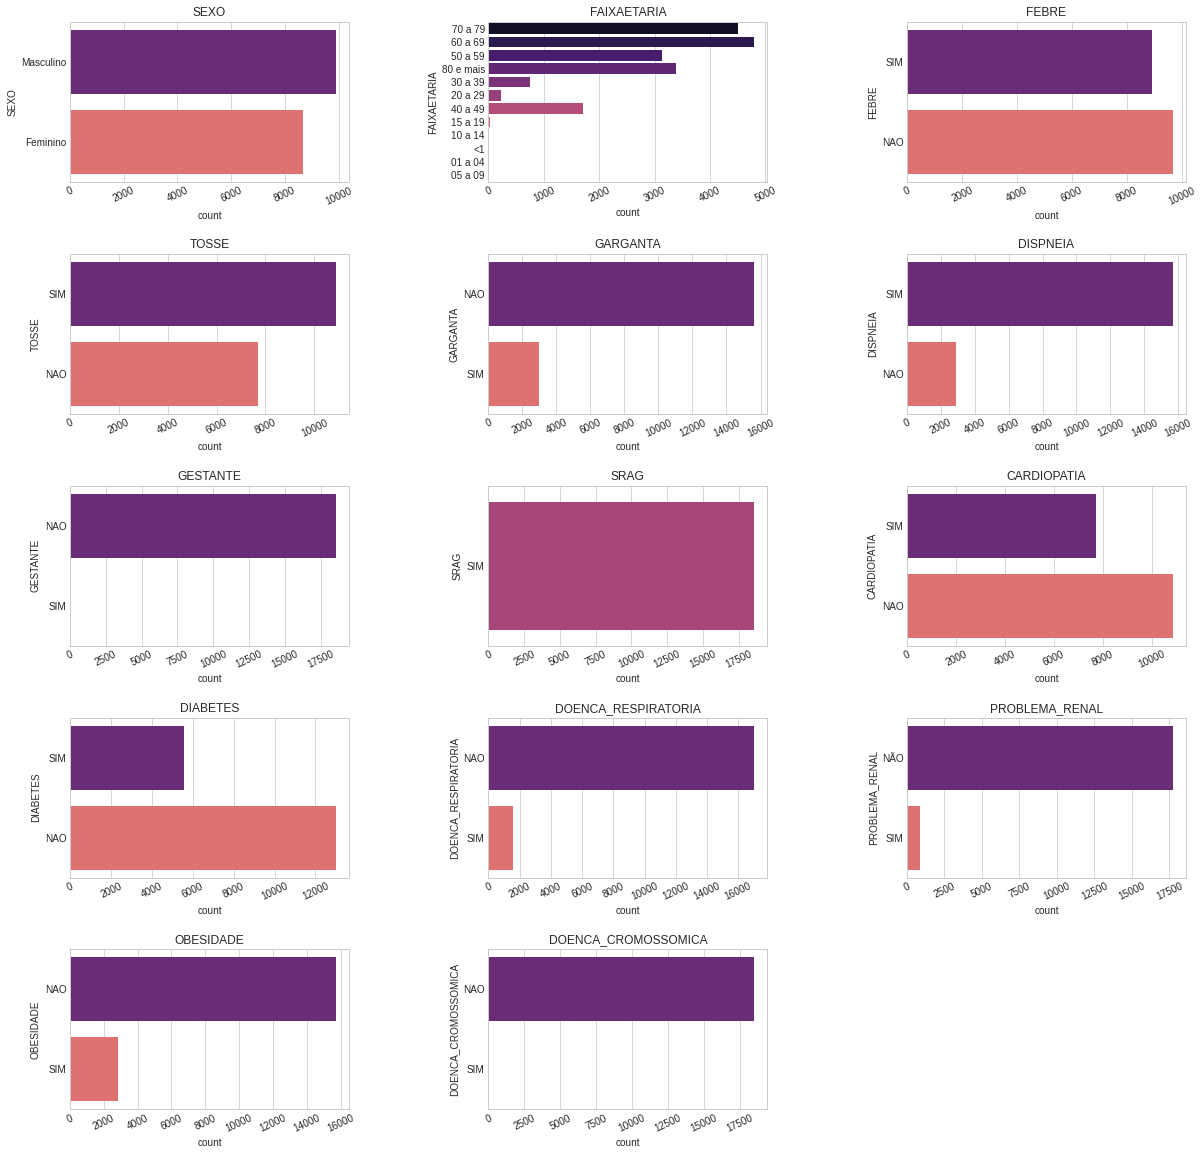

In [9]:
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset, palette="magma")
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(df_obitos.drop(['EVOLUCAO'], axis=1), cols=3, width=20, height=20, hspace=0.45, wspace=0.5)

### Chi Square

Chi-Quadrado (ou também chamado de Chi-Squared).

Chi Quadrado mede a relação de dependência entre duas variáveis categóricas, verificando como os valores esperados desviam dos valores observados.

Quando temos um alto valor de Chi-quadrado (nosso p-value será baixo), significa que temos evidência estatística para inferir que os valores observados e esperados não são os mesmos, portanto possuem dependência entre si.

Quanto mais alto o Chi-quadrado, maior a dependência entre as variáveis.

Utilizaremos o nosso nível de significancia (alpha) em 0.05. A nossa hipótese nula (h0) é de que não há diferença significativa entre os valores de cada variável dicotômica, em relação ao paciente vir a óbito ou não. Caso o valor de p seja maior que 0.5, não há evidência de difernça significativa, e então a variável não difere entre si e não explica a chance de óbito.

Exemplo: Se o p-value for maior que 0.05 na variável sexo. Significa que não há diferença significativa entre homens e mulheres que vem a óbito por covid-19.

In [10]:
# Importar metrica
from sklearn.feature_selection import chi2

from scipy.stats import chi2_contingency

In [11]:
pd.set_option('display.float_format','{:.15f}'.format)
from collections import defaultdict
chi_square = defaultdict(list)

for col in df.drop(['EVOLUCAO'], axis=1).columns:
    contigency = pd.crosstab(df[col], df['EVOLUCAO']) 
    c, p, dof, expected = chi2_contingency(contigency) 
    chi_square['Coluna'].append(col)
    chi_square['Chi Quadrado'].append(c)
    chi_square['P valor'].append(p)
    chi_square['Graus de liberdade'].append(dof)

# criando data frame a partir do dicionario com os dados
chi_df = pd.DataFrame.from_dict(chi_square)
# criar variavel para testar os menores que 0.05
chi_df["Significante"] = chi_df.apply(lambda row: row["P valor"] < 0.05, axis=1)
chi_df.sort_values(by='P valor')

,Coluna,Chi Quadrado,P valor,Graus de liberdade,Significante
1,FAIXAETARIA,52883.450503528059926,0.000000000000000,11,True
2,FEBRE,1676.571562280940498,0.000000000000000,1,True
4,GARGANTA,3416.914488585209256,0.000000000000000,1,True
5,DISPNEIA,70428.098606344821746,0.000000000000000,1,True
7,SRAG,197681.891036389453802,0.000000000000000,1,True
8,CARDIOPATIA,101764.561697978599113,0.000000000000000,1,True
9,DIABETES,35457.249444272070832,0.000000000000000,1,True
10,DOENCA_RESPIRATORIA,18951.774069129045529,0.000000000000000,1,True
11,PROBLEMA_RENAL,9000.711140657156648,0.000000000000000,1,True
12,OBESIDADE,19395.654032813366939,0.000000000000000,1,True


## [EXTRA] Feature Importance Florestas aleatórias
Florestas aleatórias consistem em um conjunto de árvores de decisão. Cada nó na árvore de decisão é uma condição de uma variável única, que objetiva dividir o conjunto de dados em dois de forma que valores de resposta semelhantes estejam no mesmo conjunto. A medida com base na qual a condição ótima (máximo local) é escolhido é chamado de *impurity*. Ao treinar uma árvore, pode-se calcular quanto cada recurso diminui a impureza ponderada em uma árvore. Para uma floresta, a diminuição da impureza de cada característica pode ser calculada e as características são classificadas de acordo com esta medida. Esta é a medida classificação de *feature importance* exposta nas implementações da Random Forest do sklearn, e existe dentro de `feature_importances_`.

Vamos utilizar de uma floresta aleatória para entender a importância das características do nosso conjunto de dados.

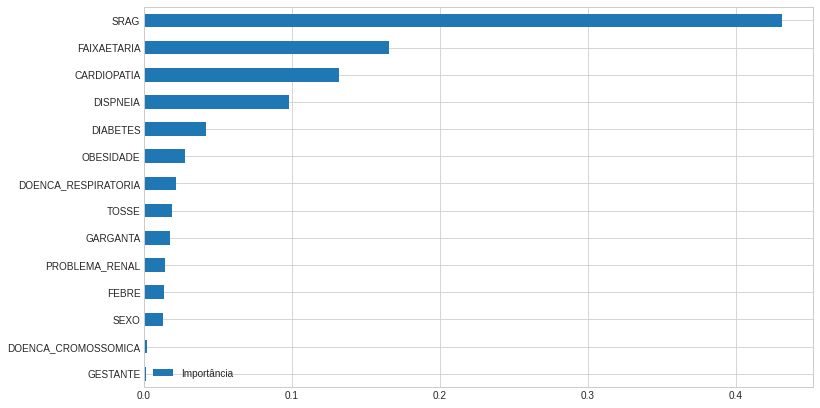

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df = df.apply(LabelEncoder().fit_transform)

df.head()

rf = RandomForestClassifier()
rf.fit(df.drop('EVOLUCAO', axis=1), df['EVOLUCAO'])

plt.style.use('seaborn-whitegrid')
importance = rf.feature_importances_
importance = pd.DataFrame(importance, index=df.drop('EVOLUCAO', axis=1).columns, columns=["Importância"])
importance.sort_values(by='Importância', ascending=True).plot(kind='barh', figsize=(12,len(importance)/2));

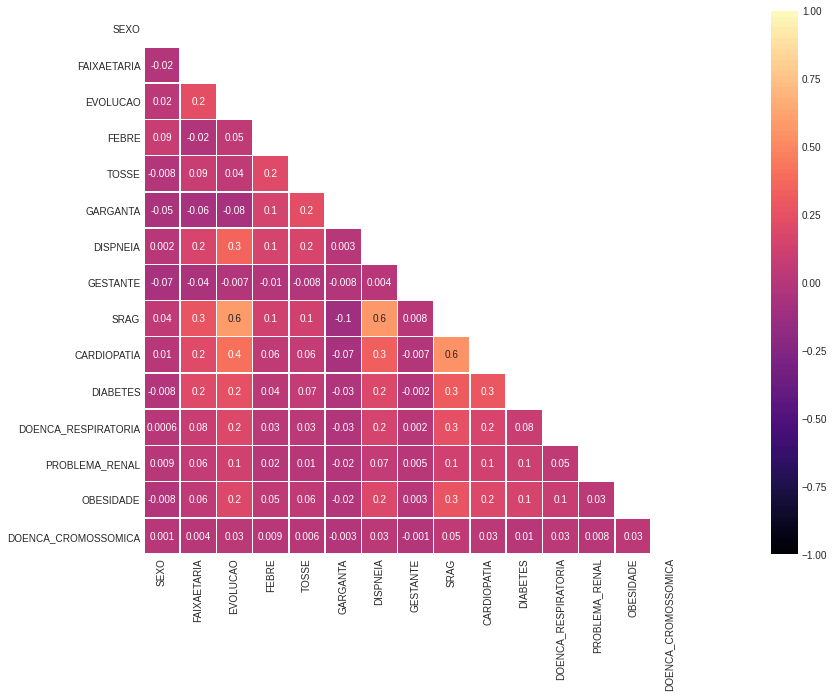

In [13]:
# matriz de correlacao
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(30,10)) 

# gerando mascara para a diagonal superior ficar vazia
mask = np.zeros_like(df.corr(method='pearson'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(method='pearson'), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("magma", 100), 
            mask=mask, 
            annot=True,
            fmt='.1g',
            linewidths=.5);